In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import LTH
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers

In [3]:
folder = './'
X = np.load(folder+'train_images.npy').reshape(-1, 784)/255
y = np.loadtxt(folder+'train_labels.csv', delimiter=',', skiprows=1).reshape(-1, 1)
X_test = np.load(folder+'test_images.npy').reshape(-1, 784)/255
y_test = pd.read_csv(folder+'test_labels.csv')['Category'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(compile_model_flag=True, lr=0.001):
    reduce = 2
    input_dim=784
    output_size = 10
#     initializer = initializers.RandomNormal(mean=0, stddev=0.1)
    initializer = initializers.glorot_normal()
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2//reduce, activation='relu', 
                    name='hidden_1', 
                    kernel_initializer=initializer,
                    input_dim=input_dim))
    model.add(Dense(784//reduce, activation='relu', 
                    name='hidden_2', 
                    kernel_initializer=initializer))
    model.add(Dense(output_size, activation='softmax', 
                    name='Salida', 
                    kernel_initializer=initializer))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 784)               615440    
_________________________________________________________________
hidden_2 (Dense)             (None, 392)               307720    
_________________________________________________________________
Salida (Dense)               (None, 10)                3930      
Total params: 927,090
Trainable params: 927,090
Non-trainable params: 0
_________________________________________________________________


In [5]:
def get_callbacks(filename):
    return [
#         ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
    ]

In [6]:
model = get_model()
epochs = 10
batch_size = 256
# Save initial weights
model.save_weights('mlp.mnist.initial_weights.hdf5')
history = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
           validation_data = (X_val, y_val),
           verbose=2, 
           callbacks=get_callbacks('mlp.mnist.first_train.hdf5')
          )

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.85144, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.5156 - accuracy: 0.8178 - val_loss: 0.4068 - val_accuracy: 0.8514
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.85144 to 0.87356, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.3644 - accuracy: 0.8669 - val_loss: 0.3584 - val_accuracy: 0.8736
Epoch 3/10

Epoch 00003: val_accuracy did not improve from 0.87356
200/200 - 0s - loss: 0.3216 - accuracy: 0.8819 - val_loss: 0.3455 - val_accuracy: 0.8728
Epoch 4/10

Epoch 00004: val_accuracy did not improve from 0.87356
200/200 - 0s - loss: 0.2984 - accuracy: 0.8909 - val_loss: 0.3648 - val_accuracy: 0.8673
Epoch 5/10

Epoch 00005: val_accuracy improved from 0.87356 to 0.87433, saving model to mlp.mnist.first_train.hdf5
200/200 - 0s - loss: 0.2772 - accuracy: 0.8956 - val_loss: 0.3434 - val_accuracy: 0.8743
Epoch 6/10

Epoch 00006: val_accuracy improved from 0.87433 to 0.88822, saving 

In [7]:
model.load_weights('mlp.mnist.first_train.hdf5')
model.evaluate(X_test, y_test, verbose=0)

[0.32567331194877625, 0.8809999823570251]

In [8]:
lth = LTH(get_model)

In [9]:
pms = np.linspace(0.001, 0.99, 50)
accs_nt = []
for pm in pms:
    # Devuelve el modelo pruneado en funcion del entrenamiento
    model_pruned_layers = lth.get_prunned_model('mlp.mnist.first_train.hdf5', pm)
    # Coloca los pesos iniciales en los lugares sin prunear
    model_pruned_layers_not_trained = lth.initialize_sparse_model('mlp.mnist.initial_weights.hdf5', model_pruned_layers, pm)
    accs_nt.append(model_pruned_layers_not_trained.evaluate(X_test, y_test)[1])

Instructions for updating:
Please use `layer.add_weight` method instead.
313/313 [==============================] - 0s 832us/step - loss: 2.2714 - accuracy: 0.1597


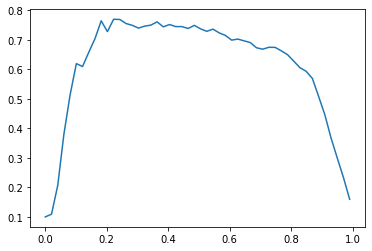

In [10]:
plt.plot(pms, accs_nt)

In [11]:
np.save('acc_not_train_prunned_10_2_reduce_2_normal_glorot_200.npy', [pms, accs_nt])

In [18]:
[pms_1, accs_nt_1] = np.load('acc_not_train_prunned_10_1_reduce_2_normal_glorot_200.npy')
[pms_2, accs_nt_2] = np.load('acc_not_train_prunned_10_2_reduce_2_normal_glorot_200.npy')

In [20]:
pms_2.shape

(50,)

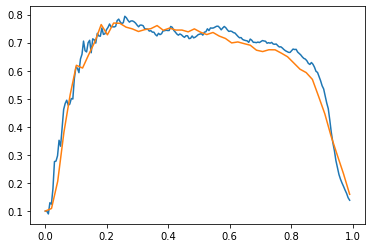

In [23]:
plt.plot(pms_1, accs_nt_1)
plt.plot(pms_2, accs_nt_2)

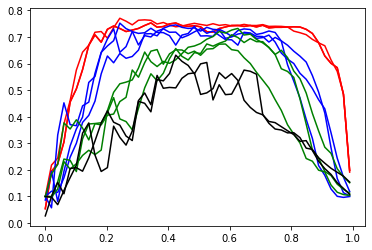

In [24]:
for i in range(3):
    accs = np.load(f'acc_not_train_prunned_10_{i+1}.npy')
    plt.plot(pms, accs, c='r')
    
for i in range(3):
    accs = np.load(f'acc_not_train_prunned_10_reduce_4_{i+1}.npy')
    plt.plot(pms, accs, c='b')
    
for i in range(3):
    accs = np.load(f'acc_not_train_prunned_10_reduce_8_{i+1}.npy')
    plt.plot(pms, accs, c='g')
    
for i in range(2):
    accs = np.load(f'acc_not_train_prunned_10_reduce_16_{i+1}.npy')
    plt.plot(pms, accs, c='k')

# How the weights move

In [117]:
unpruned_trained_model = get_model()
unpruned_trained_model.load_weights('mlp.mnist.first_train.hdf5')
model_pruned_layers = lth.get_prunned_model('mlp.mnist.first_train.hdf5', None, X_train, y_train, 0.3)
untrained_model = get_model()
untrained_model.load_weights('mlp.mnist.initial_weights.hdf5')

In [118]:
n_layer = 2
mask_l1 = model_pruned_layers.layers[n_layer].pruning_vars[0][1].numpy()
weights_l1 = unpruned_trained_model.layers[n_layer].get_weights()[0]
init_weights_l1 = untrained_model.layers[n_layer].get_weights()[0]

In [119]:
print('Movimiento de los no pruneados:\t', ((weights_l1 - init_weights_l1)*mask_l1).std())
print('Movimiento de los pruneados:\t',((weights_l1 - init_weights_l1)*(1-mask_l1)).std())

Movimiento de los no pruneados:	 0.018372707
Movimiento de los pruneados:	 0.015532026
